# importation of preprocessed data and liberys

In [1]:
def setup():
  from google.colab import drive
  import os
  drive.mount('/content/gdrive')
  os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
  %cd /content/gdrive/My Drive/Kaggle
  !kaggle competitions download -c instacart-market-basket-analysis
  !unzip products.csv.zip -d '/content/'
  !unzip orders.csv.zip -d '/content/'
  !unzip order_products__train.csv.zip -d '/content/'
  !unzip order_products__prior.csv.zip -d '/content/'
  !unzip aisles.csv.zip -d '/content/'
  !unzip departments.csv.zip -d '/content/'
if __name__ == '__main__':
  setup()

Mounted at /content/gdrive
/content/gdrive/My Drive/Kaggle
departments.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
order_products__prior.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
products.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
aisles.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
order_products__train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
orders.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  products.csv.zip
  inflating: /content/products.csv   
   creating: /content/__MACOSX/
  inflating: /content/__MACOSX/._products.csv  
Archive:  orders.csv.zip
  inflating: /content/orders.csv     

In [2]:
  #import of liberys
  import numpy as np
  import pandas as pd
  from tqdm import tqdm
  import warnings
  warnings.filterwarnings("ignore")
  import matplotlib.pyplot as plt
  from collections import Counter
  from sklearn.model_selection import GridSearchCV
  from sklearn.linear_model import LogisticRegression
  import xgboost as xgb
  from sklearn.metrics import roc_curve,auc,confusion_matrix,f1_score,make_scorer
  from sklearn.model_selection import GroupShuffleSplit
  from sklearn.model_selection import PredefinedSplit
  from sklearn.calibration import CalibratedClassifierCV
  !pip install catboost
  from catboost import CatBoostClassifier
  import seaborn as sns
  from sklearn.decomposition import PCA
  from sklearn.cluster import KMeans
  from sklearn.metrics import silhouette_score
  from sklearn.preprocessing import StandardScaler
  from sklearn.ensemble import RandomForestClassifier

     |████████████████████████████████| 67.3MB 133kB/s 


In [3]:
def get_data(flag='train'):
  '''this function will get the current features releted to next order and all history features of that user if the user belongs to train data then get the output variable i.e reordered'''
  %cd /content/
  preprocessed_data=pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Untitled folder/data/preprocessed.csv')
  orders = pd.read_csv('/content/orders.csv')
  temp=orders[orders['eval_set']==flag][['order_id','user_id','order_dow','order_hour_of_day','days_since_prior_order']]  
  preprocessed_data=pd.merge(preprocessed_data,temp,on='user_id',how='inner')
  if flag=='train':
    train_data = pd.read_csv('order_products__train.csv')
    temp2=pd.merge(orders,train_data,on='order_id',how='inner')[['user_id','product_id','reordered']]
    preprocessed_data=pd.merge(preprocessed_data,temp2,on=['user_id','product_id'],how='left')
    for i in range(len(preprocessed_data)):
      if str(preprocessed_data['reordered'][i])=='nan':
        preprocessed_data['reordered'].values[i]=0
  preprocessed_data=preprocessed_data.drop(['order_id'], axis=1)
  return preprocessed_data

In [4]:
train_data=get_data(flag='train')
test_data=get_data(flag='test')

/content
/content


# Utility functions

In [5]:
#https://www.kaggle.com/mmueller/f1-score-expectation-maximization-in-o-n/
"""
@author: Faron
"""

'''
This kernel implements the O(n²) F1-Score expectation maximization algorithm presented in
"Ye, N., Chai, K., Lee, W., and Chieu, H.  Optimizing F-measures: A Tale of Two Approaches. In ICML, 2012."

It solves argmax_(0 <= k <= n,[[None]]) E[F1(P,k,[[None]])]
with [[None]] being the indicator for predicting label "None"
given posteriors P = [p_1, p_2, ... , p_n], where p_1 > p_2 > ... > p_n
under label independence assumption by means of dynamic programming in O(n²).
'''


class F1Optimizer():
    def __init__(self):
        pass

    @staticmethod
    def get_expectations(P, pNone=None):
        expectations = []
        P = np.sort(P)[::-1]

        n = np.array(P).shape[0]
        DP_C = np.zeros((n + 2, n + 1))
        if pNone is None:
            pNone = (1.0 - P).prod()

        DP_C[0][0] = 1.0
        for j in range(1, n):
            DP_C[0][j] = (1.0 - P[j - 1]) * DP_C[0, j - 1]

        for i in range(1, n + 1):
            DP_C[i, i] = DP_C[i - 1, i - 1] * P[i - 1]
            for j in range(i + 1, n + 1):
                DP_C[i, j] = P[j - 1] * DP_C[i - 1, j - 1] + (1.0 - P[j - 1]) * DP_C[i, j - 1]

        DP_S = np.zeros((2 * n + 1,))
        DP_SNone = np.zeros((2 * n + 1,))
        for i in range(1, 2 * n + 1):
            DP_S[i] = 1. / (1. * i)
            DP_SNone[i] = 1. / (1. * i + 1)
        for k in range(n + 1)[::-1]:
            f1 = 0
            f1None = 0
            for k1 in range(n + 1):
                f1 += 2 * k1 * DP_C[k1][k] * DP_S[k + k1]
                f1None += 2 * k1 * DP_C[k1][k] * DP_SNone[k + k1]
            for i in range(1, 2 * k - 1):
                DP_S[i] = (1 - P[k - 1]) * DP_S[i] + P[k - 1] * DP_S[i + 1]
                DP_SNone[i] = (1 - P[k - 1]) * DP_SNone[i] + P[k - 1] * DP_SNone[i + 1]
            expectations.append([f1None + 2 * pNone / (2 + k), f1])

        return np.array(expectations[::-1]).T

    def __init__(self):
        pass
    @staticmethod
    def get_expectations(P, pNone=None):
        expectations = []
        P = np.sort(P)[::-1]

        n = np.array(P).shape[0]
        DP_C = np.zeros((n + 2, n + 1))
        if pNone is None:
            pNone = (1.0 - P).prod()

        DP_C[0][0] = 1.0
        for j in range(1, n):
            DP_C[0][j] = (1.0 - P[j - 1]) * DP_C[0, j - 1]

        for i in range(1, n + 1):
            DP_C[i, i] = DP_C[i - 1, i - 1] * P[i - 1]
            for j in range(i + 1, n + 1):
                DP_C[i, j] = P[j - 1] * DP_C[i - 1, j - 1] + (1.0 - P[j - 1]) * DP_C[i, j - 1]

        DP_S = np.zeros((2 * n + 1,))
        DP_SNone = np.zeros((2 * n + 1,))
        for i in range(1, 2 * n + 1):
            DP_S[i] = 1. / (1. * i)
            DP_SNone[i] = 1. / (1. * i + 1)
        for k in range(n + 1)[::-1]:
            f1 = 0
            f1None = 0
            for k1 in range(n + 1):
                f1 += 2 * k1 * DP_C[k1][k] * DP_S[k + k1]
                f1None += 2 * k1 * DP_C[k1][k] * DP_SNone[k + k1]
            for i in range(1, 2 * k - 1):
                DP_S[i] = (1 - P[k - 1]) * DP_S[i] + P[k - 1] * DP_S[i + 1]
                DP_SNone[i] = (1 - P[k - 1]) * DP_SNone[i] + P[k - 1] * DP_SNone[i + 1]
            expectations.append([f1None + 2 * pNone / (2 + k), f1])

        return np.array(expectations[::-1]).T

    @staticmethod
    def maximize_expectation(P, pNone=None):
        expectations = F1Optimizer.get_expectations(P, pNone)

        ix_max = np.unravel_index(expectations.argmax(), expectations.shape)

        predNone = True if ix_max[0] == 0 else False
        best_k = ix_max[1]

        return best_k, predNone
def print_best_prediction(product,P, pNone=None):
    #print("Maximize F1-Expectation")
    P = np.sort(P)[::-1]
    n = P.shape[0]
    #L = ['L{}'.format(i + 1) for i in range(n)]

    if pNone is None:
        #print("Estimate p(None|x) as (1-p_1)*(1-p_2)*...*(1-p_n)")
        pNone = (1.0 - P).prod()

    #PL = ['p({}|x)={}'.format(l, p) for l, p in zip(L, P)]
    #print("Posteriors: {} (n={})".format(PL, n))
    #print("p(None|x)={}".format(pNone))

    opt = F1Optimizer.maximize_expectation(P, pNone)
    best_prediction = ['None'] if opt[1] else []
    best_prediction += (product[:opt[0]])
    return best_prediction
    #print("Prediction {} yields best E[F1]n".format(best_prediction))

In [6]:
def max_f1_output(test_data,preds,flag):
  temp=pd.DataFrame()
  temp['user_id']=test_data['user_id']
  temp['product_id']=test_data['product_id']
  temp['pred_reorder'] = preds
  temp=temp.sort_values(by=['user_id','pred_reorder'], ascending=False,)
  t1=temp.groupby('user_id')['product_id'].apply(list).reset_index(name='product_ids')
  t2=temp.groupby('user_id')['pred_reorder'].apply(list).reset_index(name='proba')
  temp=pd.merge(t1,t2,on='user_id',how='inner')
  preds=[]
  for idx,row in temp.iterrows():
    preds.append(print_best_prediction(row['product_ids'],row['proba']))
  temp['products']=preds
  temp=temp.drop(['product_ids','proba'], axis=1)
  orders = pd.read_csv( '/content/orders.csv')
  test_order=orders[orders['eval_set']==flag]
  test_order=test_order[['order_id','user_id']]
  test_order=pd.merge(test_order,temp,on='user_id',how='inner')
  test_order=test_order.drop(['user_id'], axis=1)
  return test_order

In [7]:
def predict_score(X_data,preds,flag='train'):
  pred=max_f1_output(X_data,preds,flag)
  if flag=='train':
    tp=0
    fn=0
    fp=0
    f1_score=[]
    order_train=pd.read_csv( '/content/order_products__train.csv')
    order_train=order_train[order_train['reordered']==1]
    temp=pd.DataFrame(order_train.groupby('order_id')['product_id'].apply(list).reset_index(name='true_products'))
    orders=pd.read_csv( '/content/orders.csv')
    temp=pd.merge(orders,temp,on='order_id',how='left')[['order_id','true_products']]
    for i in range(len(temp)):
      if str(temp['true_products'][i])=='nan':
        temp['true_products'].values[i]=['None']
  
    temp=pd.merge(pred,temp,on='order_id',how='inner')
    temp['true_products']=temp['true_products'].apply(set)
    temp['products']=temp['products'].apply(set)

    for j, row in temp.iterrows():
      tp=len(row['products'].intersection(row['true_products']))
      pression=tp/len(row['products'])
      recall=tp/len(row['true_products'])
      if tp==0:
        f1 = 0 
      else:
        f1=2*pression*recall/(pression+recall)
      f1_score.append(f1)
    mean_f1=sum(f1_score)/len(f1_score)
    return mean_f1
  elif flag=='test':
    str_pred=[]
    for idx,row in tqdm(pred.iterrows()):
      s = [str(i) for i in row['products']]
      str_pred.append(" ".join(s))
    pred['products']=str_pred
    return pred

# Train, Test and  validation split

In [8]:


train_inds, test_inds = next(GroupShuffleSplit(test_size=.20, n_splits=2,random_state=42).split(train_data, groups=train_data['user_id']))

X_test=train_data.iloc[test_inds]
y_test=X_test['reordered']
X_test=X_test.drop(['reordered'], axis=1)

train = train_data.iloc[train_inds]
train_inds, val_inds = next(GroupShuffleSplit(test_size=.2, n_splits=2,random_state=42).split(train, groups=train['user_id']))

X_train = train.iloc[train_inds]
y_train=X_train['reordered']
X_train=X_train.drop(['reordered'], axis=1)


X_val = train.iloc[val_inds]
y_val=X_val['reordered']
X_val=X_val.drop(['reordered'], axis=1)



In [9]:

y_final=train_data['reordered']
X_final=train_data.drop(['reordered'], axis=1)

# Logistic Regression:-

In [ ]:
alpha = [10 ** x for x in range(-5, 4)]
cv_error=[]
for i in alpha:
    x_cfl=LogisticRegression(penalty='l2',C=i,class_weight='balanced')
    x_cfl.fit(X_train.iloc[:, 2:],y_train)
    print('alpha :',i)
    pred=x_cfl.predict_proba(X_train.iloc[:,2:])[:,1:]
    cv_error.append(predict_score(X_val,pred))
    print('val mean_f1 is = ',cv_error[-1])
    print("-------------------")


alpha : 1e-05


20994it [16:02, 21.82it/s]


val mean_f1 is =  0.22120731997087797
-------------------
alpha : 0.0001


20994it [15:51, 22.07it/s]


val mean_f1 is =  0.2212350976304722
-------------------
alpha : 0.001


20994it [15:57, 21.92it/s]


val mean_f1 is =  0.22123017371626363
-------------------
alpha : 0.01


20994it [15:49, 22.12it/s]


val mean_f1 is =  0.22121102619525315
-------------------
alpha : 0.1


20994it [15:54, 21.99it/s]


val mean_f1 is =  0.22110520408076764
-------------------
alpha : 1


20994it [15:51, 22.06it/s]


val mean_f1 is =  0.22123524868540967
-------------------
alpha : 10


20994it [15:57, 21.91it/s]


val mean_f1 is =  0.22123524868540967
-------------------
alpha : 100


20994it [15:33, 22.49it/s]


val mean_f1 is =  0.2212307672458563
-------------------
alpha : 1000


20994it [15:22, 22.75it/s]


val mean_f1 is =  0.22123904435090516
-------------------


In [10]:
x_cfl=LogisticRegression(penalty='l2',C=1000,class_weight='balanced')
x_cfl.fit(X_train.iloc[:, 2:],y_train)
pred=x_cfl.predict_proba(X_test.iloc[:,2:])[:,1:]
score=predict_score(X_test,pred)
print('best test local mean_f1 is = ',score)

best test local mean_f1 is =  0.22147632631637157


Kaggle Submission:-

In [11]:
x_cfl = LogisticRegression(penalty='l2',C=1000,class_weight='balanced')
x_cfl.fit(X_final.iloc[:,2:],y_final)
pred=x_cfl.predict_proba(test_data.iloc[:,2:])[:,1:]
sub=predict_score(test_data,pred,flag='test')
sub.to_csv('tuned_LR.csv',index=False)


75000it [00:09, 7570.06it/s]


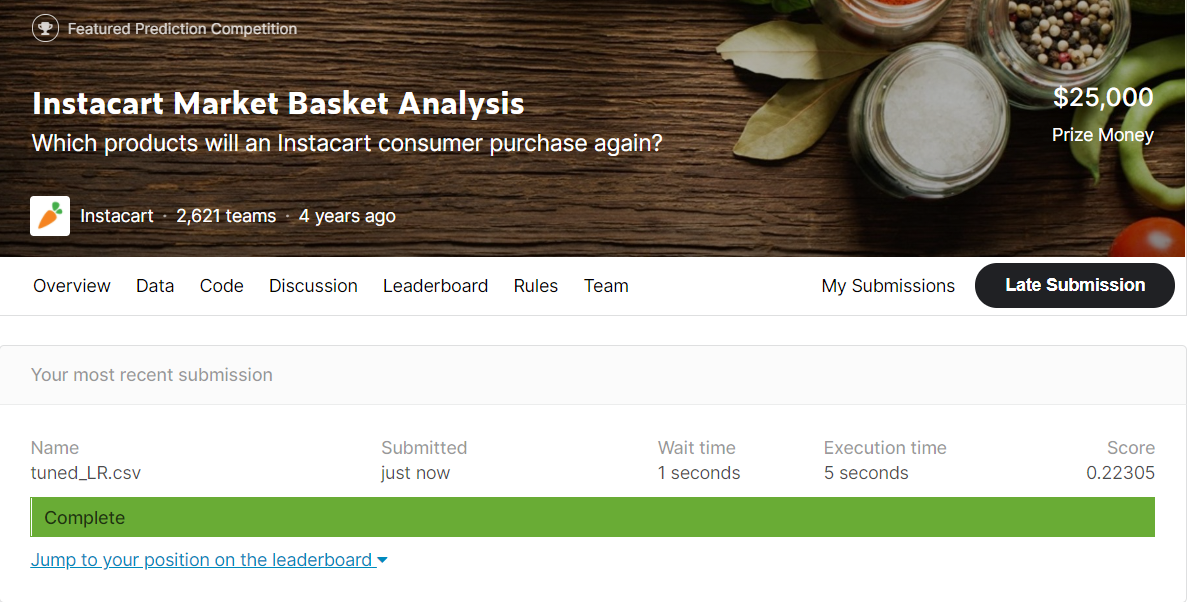

Observation:-<br>
      1.above I observed that linear methord like logistic regression is not worked well in this case so below i implemented Tree based ensamble methords.

# XGBoost Classfier

In [ ]:
max_depth=[5,7,9]
n_estimators=[500,1000,2000,3000]
learning_rates=[0.01,0.1]
cv_error=[]
for i in max_depth:
  for j in n_estimators:
    for k in learning_rates:
      x_cfl=xgb.XGBClassifier(max_depth=i,n_estimators=j,learning_rate=k,n_jobs=-1,tree_method='gpu_hist')
      x_cfl.fit(X_train.iloc[:, 2:],y_train)
      pred=x_cfl.predict_proba(X_val.iloc[:,2:])[:,1:]
      print('max_depth :',i,'and n_estimators :',j,'learning_rate :',k)
      cv_error.append(predict_score(X_val,pred))
      print('val mean_f1 is = ',cv_error[-1])
      

max_depth : 5 and n_estimators : 500 learning_rate : 0.01
val mean_f1 is =  0.38839616076015665
max_depth : 5 and n_estimators : 500 learning_rate : 0.1
val mean_f1 is =  0.3972618055813332
max_depth : 5 and n_estimators : 1000 learning_rate : 0.01
val mean_f1 is =  0.3930193553980255
max_depth : 5 and n_estimators : 1000 learning_rate : 0.1
val mean_f1 is =  0.3980970150570491
max_depth : 5 and n_estimators : 2000 learning_rate : 0.01
val mean_f1 is =  0.39578720200237083
max_depth : 5 and n_estimators : 2000 learning_rate : 0.1
val mean_f1 is =  0.3976822456635675
max_depth : 5 and n_estimators : 3000 learning_rate : 0.01
val mean_f1 is =  0.39678541349507945
max_depth : 5 and n_estimators : 3000 learning_rate : 0.1
val mean_f1 is =  0.3974281456826673
max_depth : 7 and n_estimators : 500 learning_rate : 0.01
val mean_f1 is =  0.39111621521207696
max_depth : 7 and n_estimators : 500 learning_rate : 0.1
val mean_f1 is =  0.39826829334808206
max_depth : 7 and n_estimators : 1000 learni

In [ ]:
max_depth=[5,7,9]
n_estimators=[3500,4000,5000]
cv_error=[]
for i in max_depth:
  for j in n_estimators:
      x_cfl=xgb.XGBClassifier(max_depth=i,n_estimators=j,learning_rate=0.01,n_jobs=-1,tree_method='gpu_hist')
      x_cfl.fit(X_train.iloc[:, 2:],y_train)
      pred=x_cfl.predict_proba(X_val.iloc[:,2:])[:,1:]
      print('max_depth :',i,'and n_estimators :',j,'learning_rate :',0.01)
      cv_error.append(predict_score(X_val,pred))
      print('val mean_f1 is = ',cv_error[-1])
      

max_depth : 5 and n_estimators : 3500 learning_rate : 0.01
val mean_f1 is =  0.3970756170387692
max_depth : 5 and n_estimators : 4000 learning_rate : 0.01
val mean_f1 is =  0.3975288489474437
max_depth : 5 and n_estimators : 5000 learning_rate : 0.01
val mean_f1 is =  0.39725403771788265
max_depth : 7 and n_estimators : 3500 learning_rate : 0.01
val mean_f1 is =  0.3985271621935638
max_depth : 7 and n_estimators : 4000 learning_rate : 0.01
val mean_f1 is =  0.39819595836084665
max_depth : 7 and n_estimators : 5000 learning_rate : 0.01
val mean_f1 is =  0.39806426336541545
max_depth : 9 and n_estimators : 3500 learning_rate : 0.01


In [ ]:
x_cfl=xgb.XGBClassifier(max_depth=7,n_estimators=3000,learning_rate=0.01,n_jobs=-1,tree_method='gpu_hist')
x_cfl.fit(X_train.iloc[:, 2:],y_train)
pred=x_cfl.predict_proba(X_test.iloc[:,2:])[:,1:]
score=predict_score(X_test,pred)
print('best test local mean_f1 is = ',score)

best test local mean_f1 is =  0.3978108853984191


In [ ]:
x_cfl=xgb.XGBClassifier(max_depth=7,n_estimators=3500,learning_rate=0.01,n_jobs=-1,tree_method='gpu_hist')
x_cfl.fit(X_train.iloc[:, 2:],y_train)
pred=x_cfl.predict_proba(X_test.iloc[:,2:])[:,1:]
score=predict_score(X_test,pred)
print('best test local mean_f1 is = ',score)

best test local mean_f1 is =  0.39983100422900286


Kaggle Submission:-

In [ ]:
x_cfl = xgb.XGBClassifier(max_depth=7,n_estimators=3500,learning_rate=0.01,n_jobs=-1,tree_method='gpu_hist')
x_cfl.fit(X_final.iloc[:,2:],y_final)
pred=x_cfl.predict_proba(test_data.iloc[:,2:])[:,1:]
sub=predict_score(test_data,pred,flag='test')
sub.to_csv('tuned_xgboost.csv',index=False)


75000it [00:08, 9110.75it/s]


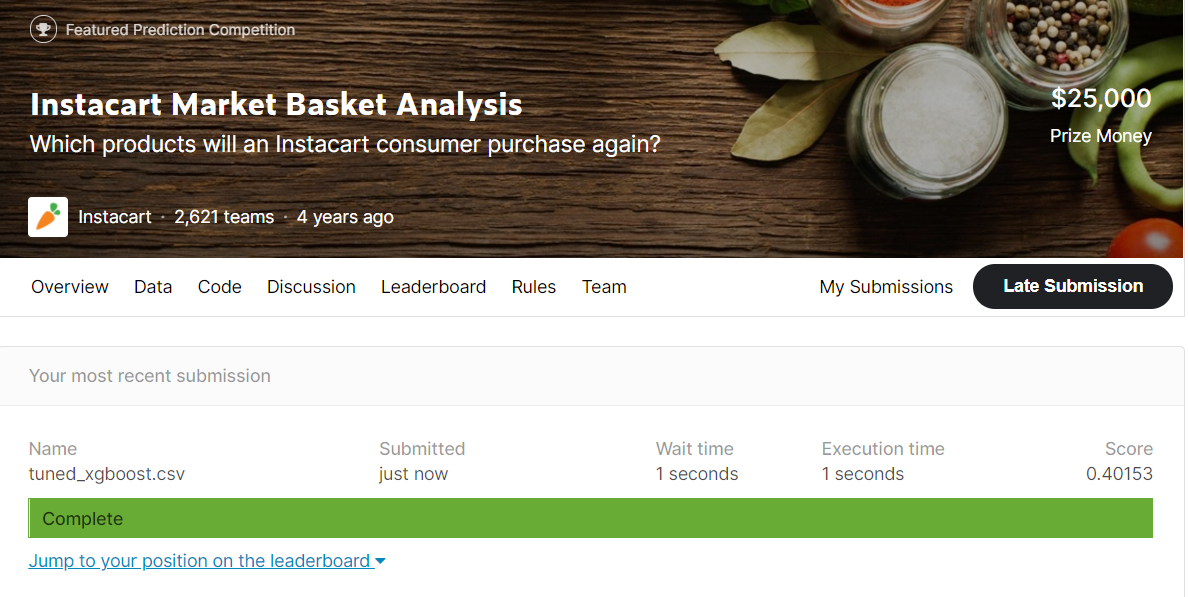

Observation:-<br>
      1.here i can say that we get a significant growth in mean f1 score when we used Xgboost insted of liner models, so in the next step i will expirment with Random forest tree based ensamble methord.

# Random Forest Classifier:-

In [ ]:
max_depth=[5,7,9]
n_estimators=[500,1000,2000,3000]
cv_error=[]
for i in max_depth:
  for j in n_estimators:
    x_cfl=RandomForestClassifier(max_depth=i,n_estimators=j,n_jobs=-1)
    x_cfl.fit(X_train.iloc[:, 2:],y_train)

    pred=x_cfl.predict_proba(X_val.iloc[:,2:])[:,1:]
    print('max_depth :',i,'and n_estimators :',j,)
    cv_error.append(predict_score(X_val,pred))
    print('val mean_f1 is = ',cv_error[-1])
    print("-------------------")

          max_depth : 5 and n_estimators : 500
          val mean_f1 is =  0.3777169325816058
          -------------------
          max_depth : 5 and n_estimators : 1000
          val mean_f1 is =  0.378092823632227
          -------------------
          max_depth : 5 and n_estimators : 2000
          val mean_f1 is =  0.37814361202934726
          -------------------
          max_depth : 5 and n_estimators : 3000
          val mean_f1 is =  0.3779344375871902
          -------------------
          max_depth : 7 and n_estimators : 500
          val mean_f1 is =  0.3829785936332684
          -------------------
          max_depth : 7 and n_estimators : 1000
          val mean_f1 is =  0.3826773270065805
          -------------------
          max_depth : 7 and n_estimators : 2000
          val mean_f1 is =  0.3827114072300839
          -------------------
          max_depth : 7 and n_estimators : 3000
          val mean_f1 is =  0.3827233214515998
          -------------------
          max_depth : 9 and n_estimators : 500
          val mean_f1 is =  0.38585036654352795
          -------------------
          max_depth : 9 and n_estimators : 1000
          val mean_f1 is =  0.38566488310708297
          -------------------
          max_depth : 9 and n_estimators : 2000
          val mean_f1 is =  0.38567142587170966
          -------------------
          max_depth : 9 and n_estimators : 3000

In [ ]:
x_cfl=RandomForestClassifier(max_depth=9,n_estimators=500,n_jobs=-1)
x_cfl.fit(X_train.iloc[:, 2:],y_train)
pred=x_cfl.predict_proba(X_test.iloc[:,2:])[:,1:]
score=predict_score(X_test,pred)
print('best test local mean_f1 is = ',score)

best test local mean_f1 is =  0.38540371909539756


Kaggle Submission:-

In [ ]:
x_cfl = RandomForestClassifier(max_depth=9,n_estimators=500,n_jobs=-1)
x_cfl.fit(X_final.iloc[:,2:],y_final)
pred=x_cfl.predict_proba(test_data.iloc[:,2:])[:,1:]
sub=predict_score(test_data,pred,flag='test')
sub.to_csv('tuned_caatboost.csv',index=False)

75000it [00:08, 8768.91it/s]


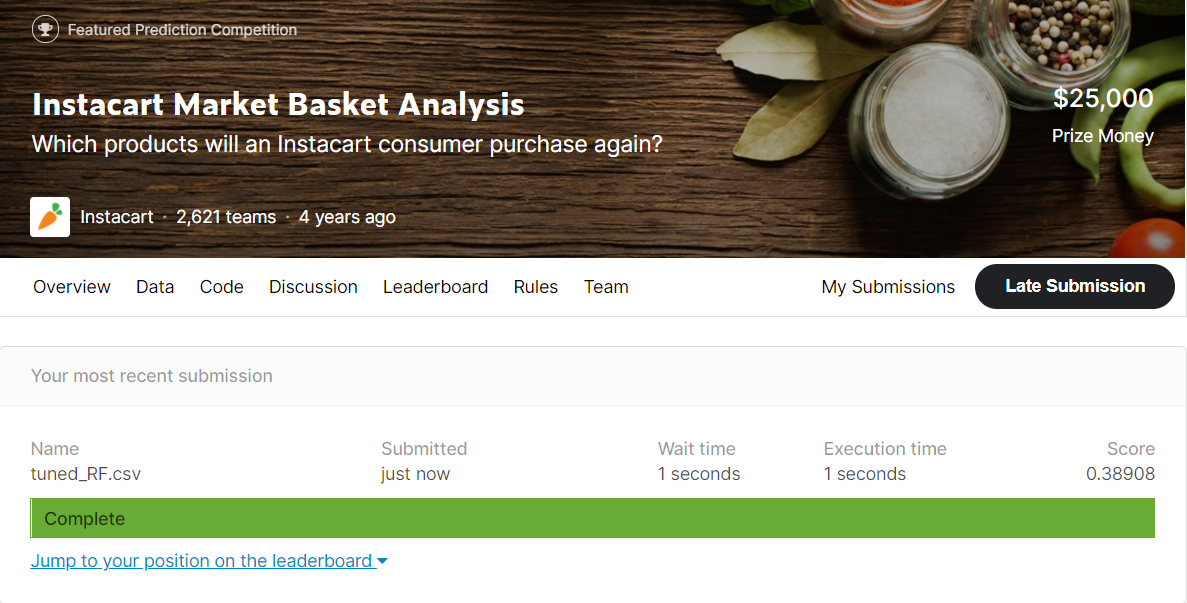

Observation:-<br>
      1.here i can observe that Xgboost is performed batter then Random Forest methord. so below i will experiment with catboost whice is worked on boosting concepts like Xgboost.

# CatBoost Classifier:-

In [ ]:
depth=[7,8,9,10]
iterations=[10000,15000,20000,25000]
cv_error=[]
for i in depth:
  for j in iterations:
    x_cfl=CatBoostClassifier(depth=i,iterations=j, learning_rate=0.01 ,task_type="GPU",verbose=0)
    x_cfl.fit(X_train.iloc[:, 2:],y_train)
    pred=x_cfl.predict_proba(X_val.iloc[:,2:])[:,1:]
    print('max_depth :',i,' n_estimators :',j,'learning_rate :',0.01)
    cv_error.append(predict_score(X_val,pred))
    print('val mean_f1 is = ',cv_error[-1])

max_depth : 7  n_estimators : 10000 learning_rate : 0.01
val mean_f1 is =  0.4008564734576534
max_depth : 7  n_estimators : 15000 learning_rate : 0.01
val mean_f1 is =  0.40103435272874416
max_depth : 7  n_estimators : 20000 learning_rate : 0.01
val mean_f1 is =  0.4010382164670951
max_depth : 7  n_estimators : 25000 learning_rate : 0.01
val mean_f1 is =  0.4012655199319452
max_depth : 8  n_estimators : 10000 learning_rate : 0.01
val mean_f1 is =  0.4010751979343722
max_depth : 8  n_estimators : 15000 learning_rate : 0.01
val mean_f1 is =  0.4012574343571594
max_depth : 8  n_estimators : 20000 learning_rate : 0.01
val mean_f1 is =  0.40154360385771065
max_depth : 8  n_estimators : 25000 learning_rate : 0.01
val mean_f1 is =  0.40105371086001995
max_depth : 9  n_estimators : 10000 learning_rate : 0.01
val mean_f1 is =  0.40104201707412873
max_depth : 9  n_estimators : 15000 learning_rate : 0.01
val mean_f1 is =  0.40093202268438305
max_depth : 9  n_estimators : 20000 learning_rate : 0.0

In [ ]:
bagging_temperatures=[0,0.2,0.7,3,7,15,21,42]
cv_error=[]
for i in bagging_temperatures:
  x_cfl=CatBoostClassifier(depth=8,iterations=20000, learning_rate=0.01 ,bagging_temperature=i,task_type="GPU",verbose=0)
  x_cfl.fit(X_train.iloc[:, 2:],y_train)
  pred=x_cfl.predict_proba(X_val.iloc[:,2:])[:,1:]
  print('max_depth : 8 n_estimators : 20000 learning_rate : 0.01 bagging_temperatures :',i)
  cv_error.append(predict_score(X_val,pred))
  print('val mean_f1 is = ',cv_error[-1])

max_depth : 8 n_estimators : 20000 learning_rate : 0.01 bagging_temperatures : 0.2
val mean_f1 is =  0.4016188704560701
max_depth : 8 n_estimators : 20000 learning_rate : 0.01 bagging_temperatures : 0.7
val mean_f1 is =  0.40138189022765414
max_depth : 8 n_estimators : 20000 learning_rate : 0.01 bagging_temperatures : 3
val mean_f1 is =  0.40096680572335314
max_depth : 8 n_estimators : 20000 learning_rate : 0.01 bagging_temperatures : 7
val mean_f1 is =  0.3995035030157301
max_depth : 8 n_estimators : 20000 learning_rate : 0.01 bagging_temperatures : 15
val mean_f1 is =  0.3991046209049922
max_depth : 8 n_estimators : 20000 learning_rate : 0.01 bagging_temperatures : 21
val mean_f1 is =  0.39952368838023383
max_depth : 8 n_estimators : 20000 learning_rate : 0.01 bagging_temperatures : 42
val mean_f1 is =  0.2680674500104882


In [ ]:
x_cfl=CatBoostClassifier(depth=8,iterations=20000, learning_rate=0.01 ,bagging_temperature=0.2,task_type="GPU",verbose=0)
x_cfl.fit(X_train.iloc[:, 2:],y_train)
pred=x_cfl.predict_proba(X_test.iloc[:,2:])[:,1:]
score=predict_score(X_test,pred)
print('best test local mean_f1 is = ',score)

best test local mean_f1 is =  0.40162925080296474


Kaggle Submission:-

In [ ]:
x_cfl = CatBoostClassifier(depth=8,iterations=20000, learning_rate=0.01 ,bagging_temperature=0.2,task_type="GPU",verbose=0)
x_cfl.fit(X_final.iloc[:,2:],y_final)
pred=x_cfl.predict_proba(test_data.iloc[:,2:])[:,1:]
sub=predict_score(test_data,pred,flag='test')
sub.to_csv('tuned_caatboost.csv',index=False)

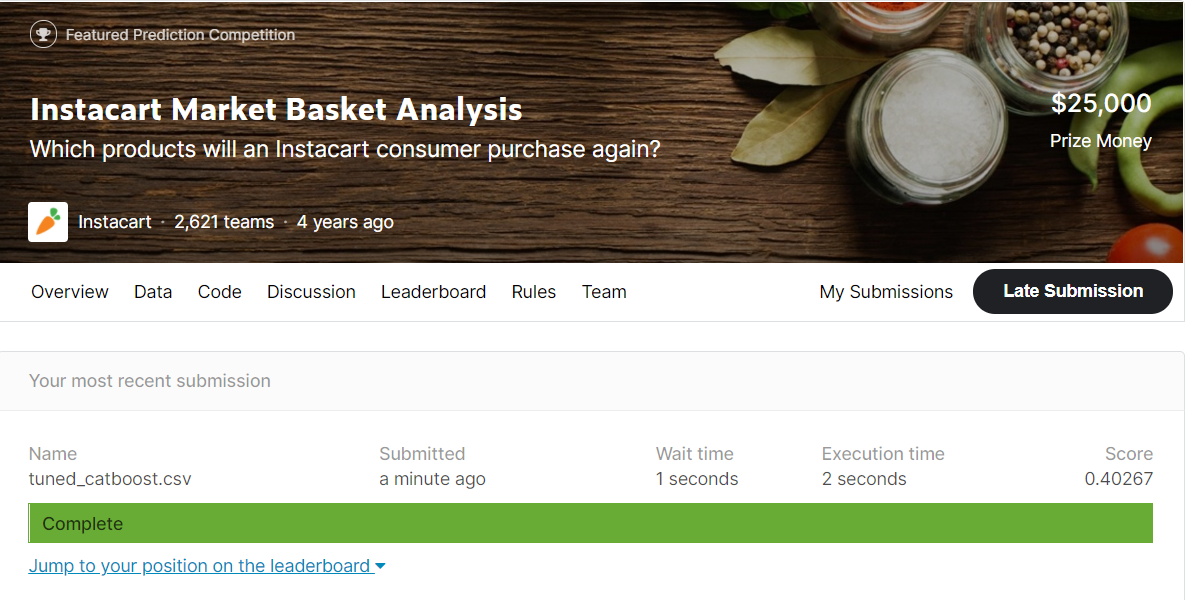

Observation:-<br>
      1.here i can say that catboost is performed well as compared to other models. so to increase the preformance below we add some pca features.

# Addition of PCA features:-

In [ ]:
#https://www.kaggle.com/asindico/customer-segments-with-pca?scriptVersionId=1625450
def get_pca_data():
  #reading all csv files.
  %cd "/content"
  data_path="/content/"
  prior_data = pd.read_csv( data_path + 'order_products__prior.csv')
  train_data = pd.read_csv( data_path + 'order_products__train.csv')
  orders = pd.read_csv( data_path + 'orders.csv')
  products=pd.read_csv( data_path + 'products.csv')
  aisles=pd.read_csv( data_path + 'aisles.csv')
  mt = pd.merge(prior_data,products, on = ['product_id'])
  mt = pd.merge(mt,orders,on=['order_id'])
  mt = pd.merge(mt,aisles,on=['aisle_id'])
  cust_prod = pd.crosstab(mt['user_id'], mt['aisle'])
  scaler = StandardScaler()
  scaler.fit(cust_prod) 
  cust_prod = scaler.transform(cust_prod)
  return cust_prod
cust_prod=get_pca_data()

/content


In [ ]:
def use_pca(data,components):
  pca = PCA(n_components=components)
  pca.fit(data)
  pca_samples = pca.transform(data)
  ps = pd.DataFrame(pca_samples)
  ps['user_id']=np.arange(1,206210)
  return ps

In [ ]:
cv_score=[]
for i in range(3,11):
  pca=use_pca(cust_prod,i)
  X_train_pca=pd.merge(X_train,pca,on=['user_id'],how='inner')
  X_val_pca=pd.merge(X_val,pca,on=['user_id'],how='inner')
  x_cfl=CatBoostClassifier(depth=8,iterations=20000, learning_rate=0.01 ,bagging_temperature=0.2,task_type="GPU",verbose=0)
  x_cfl.fit(X_train_pca.iloc[:,2:],y_train)
  print('pca components=',i)
  pred=x_cfl.predict_proba(X_val_pca.iloc[:,2:])[:,1:]
  score=predict_score(X_val_pca,pred)
  cv_score.append(score)
  print('val mean_f1 is ',score)

pca components= 3
val mean_f1 is  0.4025127876643958
pca components= 4
val mean_f1 is  0.4026538060315277
pca components= 5
val mean_f1 is  0.4024692612710879
pca components= 6
val mean_f1 is  0.402916710114933
pca components= 7
val mean_f1 is  0.4025674579932241
pca components= 8
val mean_f1 is  0.4022092228334921
pca components= 9
val mean_f1 is  0.4020130398081357
pca components= 10
val mean_f1 is  0.4021346817283395


In [ ]:
pca=use_pca(cust_prod,6)
X_train_pca=pd.merge(X_train,pca,on=['user_id'],how='inner')
X_test_pca=pd.merge(X_test,pca,on=['user_id'],how='inner')
x_cfl=CatBoostClassifier(depth=8,iterations=20000, learning_rate=0.01 ,bagging_temperature=0.2,task_type="GPU",verbose=0)
x_cfl.fit(X_train_pca.iloc[:, 2:],y_train)
pred=x_cfl.predict_proba(X_test_pca.iloc[:,2:])[:,1:]
score=predict_score(X_test_pca,pred)
print('best test local mean_f1 is = ',score)

best test local mean_f1 is =  0.4018737836476484


Kaggle Submission:-

In [ ]:
pca=use_pca(cust_prod,6)
X_final_pca=pd.merge(X_final,pca,on=['user_id'],how='inner')
test_data_pca=pd.merge(test_data,pca,on=['user_id'],how='inner')


In [ ]:
x_cfl=CatBoostClassifier(depth=8,iterations=20000, learning_rate=0.01 ,bagging_temperature=0.2,task_type="GPU",verbose=0)
x_cfl.fit(X_final_pca.iloc[:,2:],y_final)
pred=x_cfl.predict_proba(test_data_pca.iloc[:,2:])[:,1:]
sub=predict_score(test_data_pca,pred,flag='test')
sub.to_csv('tuned_Catboost_pca.csv',index=False)

75000it [00:05, 14474.40it/s]


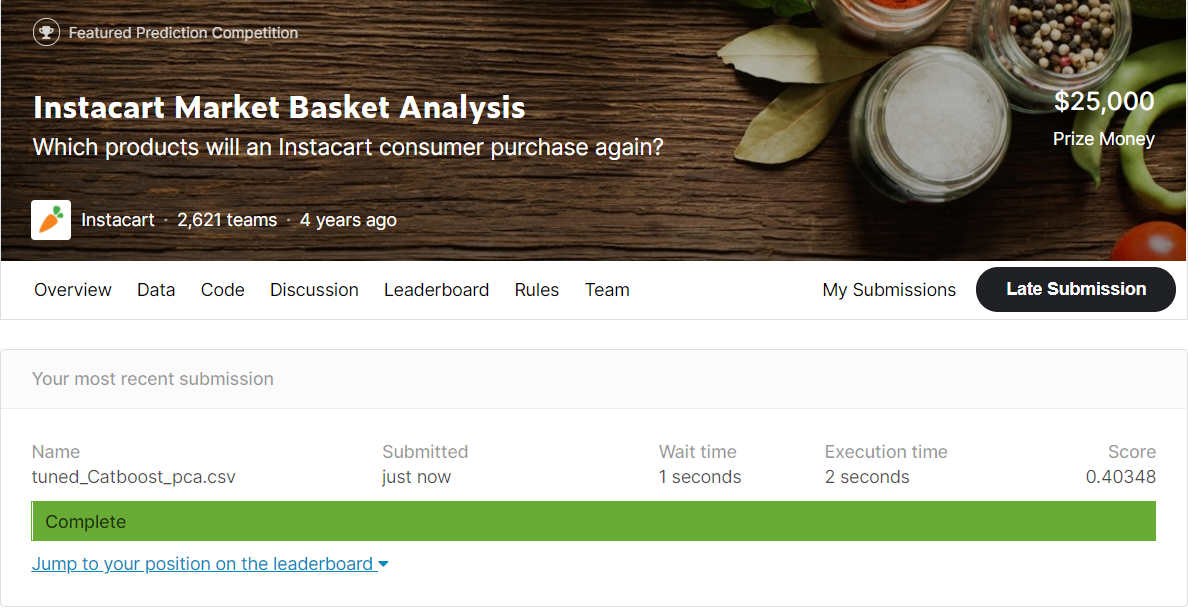

Observation:-<br>
      1.here i can say that after adding the pca feature and with Catboost model we got a good decent mean f1 score.

# Summary:-

1.Here in this case i used mean of F1 measure over all the user as performance metric. so to maxmize the F1 score there are two approach:-<br>
> first one is after getting the probability from the model we can find a global optimal threshold and then label each output according to that threshold.<br> here in this case we found the threshold as 0.19.

> second one is to get threshold for each order whice gives max f1 score for that order. <br>here in this case we get 2% boost in performance by using the 2nd methord so here in the notebook i have shown all output according to the second methord. 

2.First I trained a liner model and observed that it is not performed well so i switch to tree based bagging and boosting ensamble models.<br>

3.Then I trained Xgboost model whice is a boosting based ensamble methord and got a significant growth then a liner model.<br>
4.Then i also experimented with random forest model whice is a bagging based ensamble model and its not performed well as compared to xgboost. so after that i train catboost model whice is also a boosting based ensamble model.<br>
5.finally Catboost model is performed well as compared to other models then to improve the performance further i add pca feature using the purchase pattern of users from different aisle.<br>
6.then i also tried to removed some less important feature but i observed that the performance getting droped means we lossing some information so i removed that part.<br>
7.finally i can say that using catboost model on our previous feature set(40)and new pca features(6) i the get best performance(mean_f1~0.4035).<br>